In [2]:
import pandas as pd 
import numpy as np
import json
import requests
import os 
from os import makedirs
from os.path import join, exists
from datetime import date, timedelta

import re
import string
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

import spacy
nlp = spacy.load("en_core_web_sm")

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import LatentDirichletAllocation as LDA
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

from bokeh.io import output_file, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category20b, cividis, inferno
from bokeh.plotting import figure
from bokeh.transform import factor_cmap

# Load Data 

In [3]:
articles_dir = "data"

In [4]:
df = pd.read_csv(os.path.join(articles_dir,"df_guardian_nov14.csv"), index_col=0)

In [5]:
df.head(3)

,type,sectionId,sectionName,webPublicationDate,webTitle,webUrl,apiUrl,fields,isHosted,pillarId,pillarName,trailText,full_text,title_subtitle
id,,,,,,,,,,,,,,
society/2020/jan/18/expert-questions-effectiveness-airport-screening-new-coronavirus,article,society,Society,2020-01-18T19:20:36Z,Expert questions effectiveness of coronavirus ...,https://www.theguardian.com/society/2020/jan/1...,https://content.guardianapis.com/society/2020/...,{'headline': 'Expert questions effectiveness o...,False,pillar/news,News,We don’t know enough yet to be sure of catchin...,Medical staff at airports trying to screen for...,Expert questions effectiveness of coronavirus ...
world/2020/jan/18/no-airport-screening-for-new-sars-like-virus-yet-china,article,world,World news,2020-01-18T19:20:36Z,No screening for new Sars-like virus at UK air...,https://www.theguardian.com/world/2020/jan/18/...,https://content.guardianapis.com/world/2020/ja...,{'headline': 'No screening for new Sars-like v...,False,pillar/news,News,Experts decide no need for checks as member of...,Health officials have ruled out introducing sc...,No screening for new Sars-like virus at UK air...
world/2020/jan/18/coronavirus-what-airport-measures-are-in-place-to-detect-for-sick-passengers,article,world,World news,2020-01-18T09:21:23Z,Coronavirus: what airport measures are in plac...,https://www.theguardian.com/world/2020/jan/18/...,https://content.guardianapis.com/world/2020/ja...,{'headline': 'Coronavirus: what airport measur...,False,pillar/news,News,"Three US airports introduce screening, followi...",International airports are stepping up screeni...,Coronavirus: what airport measures are in plac...


## Data cleaning and pre-processing

Bag of words

In [6]:
def text_to_bow(text):
    '''
    convert text to just lowercase words
    '''
    # optional if dealing with strings which might contain nan 
    if text == np.nan:
        return text 
    else: 
        text = str(text).lower()
        text = re.sub('\n', ' ', text) 
        text = re.sub('<br>', ' ', text) 
        # remove non alphanumeric characters
        regex = re.compile('[^0-9a-zA-Z- ]')
        text = regex.sub('', text)
        text = re.sub(' +', ' ', text).strip()
        return text

In [7]:
df['title_subtitle_bow'] = df['title_subtitle'].apply(lambda x : text_to_bow(x))

Lemmatized bag of words

In [8]:
def spacy_lemmatize(text_list):
    lemmatized_text = []
    for text in text_list:
        doc = nlp(text_to_bow(text))
        doc_tokens = []
        for token in doc:
            if token.is_stop == False:
                doc_tokens.append(token.lemma_)
        lemmatized_text.append(" ".join(doc_tokens))
    return lemmatized_text

In [9]:
df = pd.read_csv("data/df_guardian_lem_nov14.csv", index_col=0)

In [10]:
df["date"] = pd.to_datetime(df["webPublicationDate"].apply(lambda x : x.split("T")[0]))
df['date'] = pd.to_datetime(df['date'])

In [11]:
df.head(3)

,type,sectionId,sectionName,webPublicationDate,webTitle,webUrl,apiUrl,fields,isHosted,pillarId,pillarName,trailText,full_text,title_subtitle,title_subtitle_bow,title_subtitle_lem,date
id,,,,,,,,,,,,,,,,,
society/2020/jan/18/expert-questions-effectiveness-airport-screening-new-coronavirus,article,society,Society,2020-01-18T19:20:36Z,Expert questions effectiveness of coronavirus ...,https://www.theguardian.com/society/2020/jan/1...,https://content.guardianapis.com/society/2020/...,{'headline': 'Expert questions effectiveness o...,False,pillar/news,News,We don’t know enough yet to be sure of catchin...,Medical staff at airports trying to screen for...,Expert questions effectiveness of coronavirus ...,expert questions effectiveness of coronavirus ...,expert question effectiveness coronavirus airp...,2020-01-18
world/2020/jan/18/no-airport-screening-for-new-sars-like-virus-yet-china,article,world,World news,2020-01-18T19:20:36Z,No screening for new Sars-like virus at UK air...,https://www.theguardian.com/world/2020/jan/18/...,https://content.guardianapis.com/world/2020/ja...,{'headline': 'No screening for new Sars-like v...,False,pillar/news,News,Experts decide no need for checks as member of...,Health officials have ruled out introducing sc...,No screening for new Sars-like virus at UK air...,no screening for new sars-like virus at uk air...,screening new sars - like virus uk airport exp...,2020-01-18
world/2020/jan/18/coronavirus-what-airport-measures-are-in-place-to-detect-for-sick-passengers,article,world,World news,2020-01-18T09:21:23Z,Coronavirus: what airport measures are in plac...,https://www.theguardian.com/world/2020/jan/18/...,https://content.guardianapis.com/world/2020/ja...,{'headline': 'Coronavirus: what airport measur...,False,pillar/news,News,"Three US airports introduce screening, followi...",International airports are stepping up screeni...,Coronavirus: what airport measures are in plac...,coronavirus what airport measures are in place...,coronavirus airport measure place detect sick ...,2020-01-18


# Bag of Words
Note: To get the equivalent for Tfidf, just replace the CountVectorizer with TfidfVectorizer from sklearn

In [12]:
class BagOfWords:
    def __init__(self, data, max_df, min_df, stop_words, ngram_range):
        self.data = data
        self.max_df = max_df 
        self.min_df = min_df 
        self.stop_words = stop_words 
        self.ngram_range = ngram_range 
        self.MyCountVectorizer = CountVectorizer(
            max_df=self.max_df, 
            min_df=self.min_df, 
            stop_words=self.stop_words, 
            ngram_range=self.ngram_range)
        # init the empty vars 
        self.X = ""
        self.feature_names = ""
        self.counts = ""
        self.df_counts = ""
        self.dict_counts = ""
        self.wordcloud = ""
        self.p = ""
        
        
    #fit the count vectorizer 
    def fit_transform(self):
        self.X = self.MyCountVectorizer.fit_transform(self.data)
        
    def get_feature_names(self):
        self.feature_names = self.MyCountVectorizer.get_feature_names()
        
    def get_bow_feature_counts(self): 
        self.counts = self.X.toarray().sum(axis=0)
        # create a df with feature names and counts 
        self.df_counts = pd.DataFrame({"feature_names": self.feature_names, "counts": self.counts}).sort_values(by="counts", ascending=False)
    
    # get the data into a dict format of {word: freq} type to feed into the wordcloud 
    def prep_for_wordcloud(self):
        _dict_counts = self.df_counts.set_index("feature_names").to_dict(orient="index")
        self.dict_counts = {}
        for keyword, count in _dict_counts.items():
            self.dict_counts[keyword] = count['counts']
    
    # visualise the word cloud
    def viz_wordcloud(self, background_color="black", max_words=200, width=700, height=400):
        self.wordcloud = WordCloud(background_color=background_color, max_words=max_words, width=width, height=height)
        self.wordcloud.generate_from_frequencies(self.dict_counts)
        #self.wordcloud.to_image()
        
    # bar chart of word frequencies 
    def barchart_wordfreq(self, 
                          num_top_features=30,
                          output_here=True, save_filename="plot", 
                          plot_height=350, plot_width=800, title="Title", bgcolor = "#2b2b2b"):
        
        counted_data = self.df_counts.nlargest(num_top_features, "counts")["feature_names"].tolist()
        counts = self.df_counts.nlargest(num_top_features, "counts")["counts"].tolist()
        # either display in the notebook or save file 
        if output_here:
            output_notebook()
        else:
            output_file(save_filename+".html")
        
        source = ColumnDataSource(data=dict(counted_data=counted_data, counts=counts))
        self.p = figure(x_range=counted_data, plot_height=plot_height, plot_width=plot_width, toolbar_location=None, title=title)
    
        self.p.vbar(x='counted_data',
           top='counts', 
           width=0.8, 
           source=source, 
           line_color='white', 
           fill_color=factor_cmap('counted_data', palette=cividis(len(counted_data)), factors=counted_data))
    
        self.p.xgrid.grid_line_color = None
        self.p.ygrid.grid_line_color = None
        self.p.y_range.start = 0
        self.p.xaxis.major_label_orientation = 1.2
        #p.y_range.end = 5000
        self.p.background_fill_color = bgcolor
    
        show(self.p)

### 1-grams with the bow data 

In [13]:
# initialize the count vectorizer 
bow = BagOfWords(data=df['title_subtitle_bow'], max_df=0.99, min_df=0.005, stop_words="english", ngram_range=(1, 1))
# fit transform and get the fit-transformed matrix of word frequencies
bow.fit_transform() #bow_bow.X
# get the feature names 
bow.get_feature_names() #bow.feature_names
# get the feature counts 
bow.get_bow_feature_counts() #bow.df_counts

In [14]:
print("Number of features: {}".format(len(bow.feature_names)))

Number of features: 619


In [15]:
bow.df_counts.head(5)

,feature_names,counts
108,coronavirus,3455
566,uk,2646
113,covid,2370
469,says,1633
3,19,1516


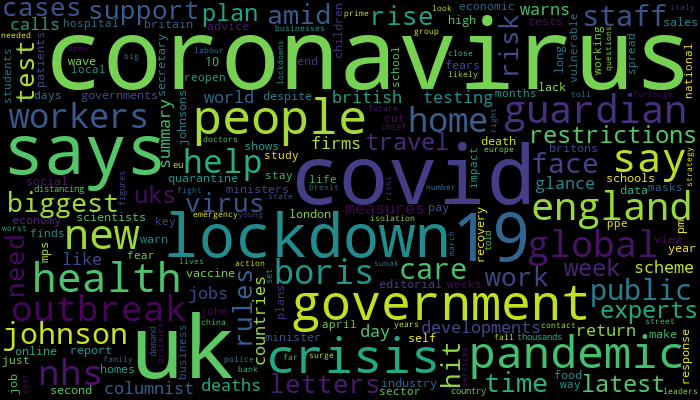

In [16]:
# wordcloud 
bow.prep_for_wordcloud()
bow.viz_wordcloud()
bow.wordcloud.to_image()

In [17]:
bow.barchart_wordfreq(num_top_features=50, plot_width=1000)
#show(bow.p)

Loading BokehJS ...

# Topic modelling with LDA

# Spacy features

## Part of speech 
- Counting the number of nouns, noun phrases, verbs, adjectives etc

In [18]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [19]:
wanted_pos = ['PROPN', "VERB", "NOUN", "ADV", "ADJ"]

Utility functions 

In [20]:
# for a single string of text, return a list of the words of the desired pos type
# and a list of the corresponding lemmas 
def collect_pos(pos, text, stopword=False):
    pos_text = []
    pos_lemma = []
    doc = nlp(text)
    for token in doc:
        if token.pos_ == pos and token.is_stop == False:
            pos_text.append(token.text)
            pos_lemma.append(token.lemma_)
    return pos_text, pos_lemma

In [36]:
def collect_noun_chunks(text):
    noun_chunks = []
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        noun_chunks.append(chunk.text)
    return noun_chunks

/Users/user/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### noun chunks

In [37]:
noun_chunks = []
for text in df["title_subtitle_bow"].tolist():
    noun_chunks.extend(collect_noun_chunks(text))
noun_chunks_counts = pd.Series(noun_chunks).value_counts()

/Users/user/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
noun_chunks_counts.head(20)

/Users/user/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


coronavirus                        1317
it                                  673
uk                                  604
we                                  603
who                                 402
they                                393
covid-19                            374
what                                328
people                              327
lockdown                            304
i                                   289
england                             281
you                                 261
the uk                              258
us                                  243
a glance                            222
the global coronavirus outbreak     217
the biggest developments            214
a summary                           205
boris johnson                       178
dtype: int64

### visualising pos frequecies 
over the entire corpus. 

In [39]:
def collect_pos(text):
    doc = nlp(text)
    nouns, verbs, adverbs, adjectives, other_pos = [], [], [], [], []
    for token in doc: 
        if token.pos_ == "NOUN" or token.pos_ == "PROPN":
            nouns.append(token.lemma_)
        elif token.pos_ == "VERB":
            verbs.append(token.lemma_)
        elif token.pos_ == "ADV":
            adverbs.append(token.lemma_)
        elif token.pos_ == "ADJ":
            adjectives.append(token.lemma_)
        else:
            other_pos.append(token.text)
    return nouns, verbs, adverbs, adjectives, other_pos

/Users/user/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
nouns_all, verbs_all, adverbs_all, adjectives_all, other_pos_all =  [], [], [], [], []
for text in df['title_subtitle_bow'].tolist():
    nouns, verbs, adverbs, adjectives, other_pos = collect_pos(text)
    nouns_all.extend(nouns)
    verbs_all.extend(verbs)
    adverbs_all.extend(adverbs)
    adjectives_all.extend(adjectives)
    other_pos_all.extend(other_pos)

/Users/user/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
len(nouns_all)

/Users/user/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


87324

In [42]:
all_pos = {}
all_pos['nouns'] = len(nouns_all)
all_pos['verbs'] = len(verbs_all)
all_pos['adverbs'] = len(adverbs_all)
all_pos['adjectives'] = len(adjectives_all)

/Users/user/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
all_pos

/Users/user/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'nouns': 87324, 'verbs': 34090, 'adverbs': 6339, 'adjectives': 18165}

In [44]:
from bokeh.io import output_file, show
from bokeh.palettes import Category20c, cividis
from bokeh.plotting import figure
from bokeh.transform import cumsum
from math import pi

/Users/user/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
data_viz = pd.DataFrame.from_dict(all_pos, orient="index").reset_index()
data_viz.columns = ['pos', 'value']

/Users/user/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
#data = pd.DataFrame({"pos": ["nouns", "verbs"], "value" : [len(all_nouns), len(all_verbs)]})
data_viz['angle'] = data_viz['value']/data_viz['value'].sum() * 2*pi
data_viz['color'] = cividis(4)

p = figure(plot_height=350, title="Frequency of each pos type", toolbar_location=None,
           tools="hover", tooltips="@pos: @value", x_range=(-0.5, 1.0))

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='pos', source=data_viz)

p.axis.axis_label=None
p.axis.visible=False
p.grid.grid_line_color = None

show(p)

/Users/user/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Named Enetity Recognition 

### visualising named entities 

In [47]:
from spacy import displacy
text = df['title_subtitle'].tolist()[3703]
doc = nlp(text)
displacy.serve(doc, style="ent")

/Users/user/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/user/Library/Python/3.8/lib/python/site-packages/spacy/displacy/__init__.py:94: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


In [48]:
def get_all_entities(text_series, text_field):
    df_ents_all = []
    for text, index in zip(text_series[text_field], text_series[text_field].index):
        doc = nlp(text)
        ents = [(e.text, e.start_char, e.end_char, e.label_) for e in doc.ents]
        df_ents = pd.DataFrame(ents)
        df_ents['index'] = index
        df_ents['text'] = text 
        df_ents_all.append(df_ents)
    df_ents_all= pd.concat(df_ents_all)
    df_ents_all.columns = ["entity", "start_pos", "end_pos", "type", "index", "text"]
    return df_ents_all

/Users/user/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
df_ents_all = get_all_entities(df, 'title_subtitle')

/Users/user/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
df_ents_all.head()

/Users/user/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,entity,start_pos,end_pos,type,index,text
0,Wellcome Trust,139.0,153.0,ORG,society/2020/jan/18/expert-questions-effective...,Expert questions effectiveness of coronavirus ...
0,UK,40.0,42.0,GPE,world/2020/jan/18/no-airport-screening-for-new...,No screening for new Sars-like virus at UK air...
1,Coronavirus,106.0,117.0,PERSON,world/2020/jan/18/no-airport-screening-for-new...,No screening for new Sars-like virus at UK air...
2,"1,700",139.0,144.0,CARDINAL,world/2020/jan/18/no-airport-screening-for-new...,No screening for new Sars-like virus at UK air...
3,China,148.0,153.0,GPE,world/2020/jan/18/no-airport-screening-for-new...,No screening for new Sars-like virus at UK air...


### visualise most common entities per category

In [51]:
ents = df_ents_all.groupby("entity").nunique()[['text']]
ents.columns =['num']
ents = ents.sort_values(by='num', ascending=False).head(200)

/Users/user/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
df_ents_top = ents.join(df_ents_all.drop_duplicates(subset=['entity'])[['entity', 'type']].set_index("entity")).reset_index()

/Users/user/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
df_ent= df_ents_top[1:].copy()
group_ent = df_ent.groupby(['type', 'entity'])
index_cmap_ent = factor_cmap('type_entity', 
                             palette=cividis(len(df_ents_top["type"].unique())), 
                             factors=df_ents_top["type"].unique(), end=1)

/Users/user/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
p = figure(plot_width=2200, plot_height=600, title="Most frequent named entities per category",
           x_range=group_ent, toolbar_location=None,
          tooltips=[("Num", "@num_mean"), ("Entity type, entity", "@type_entity")])

p.vbar(x='type_entity', top='num_mean', width=1, source=group_ent,
       line_color="white", fill_color=index_cmap_ent, )

p.y_range.start = 0
p.x_range.range_padding = 0.05
p.xgrid.grid_line_color = None
p.xaxis.axis_label = "Most common entities by type"
p.xaxis.major_label_orientation = 1.5
p.outline_line_color = None
p.background_fill_color = "#2b2b2b"

show(p)

/Users/user/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Sentimenet Analysis 

### Transformers Sentiment Analysis